# **Training a CNN from scratch to classify the CIFAR-10 dataset**
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The accuracy of the small model from scratch is around 88.67% by 30 training epochs. This model has a VGG architecture and uses techniques such as L2 regularization, reducing learning rate, early stopping, and data augumentation to increase the accuracy. Run time on a GPU is around 1268 seconds. Data loading time is around 5 seconds.

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Optional, Tuple
from torch.utils.data import Dataset, DataLoader
import time
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import s3fs
torch.manual_seed(17)

Matplotlib is building the font cache; this may take a moment.


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU
Tesla T4


## Data processing

In [3]:
s3 = s3fs.S3FileSystem()

In [19]:
from PIL import Image
from torchvision.datasets import VisionDataset
import os
import pickle

# CIFAR10 Class modified to work with S3 Bucket
class My_CIFAR10(VisionDataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    base_folder = "cifar-10-batches-py"
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = "c58f30108f718f92721af3b95e74349a"
    train_list = [
        ["data_batch_1", "c99cafc152244af753f735de768cd75f"],
        ["data_batch_2", "d4bba439e000b95fd0a9bffe97cbabec"],
        ["data_batch_3", "54ebc095f3ab1f0389bbae665268c751"],
        ["data_batch_4", "634d18415352ddfa80567beed471001a"],
        ["data_batch_5", "482c414d41f54cd18b22e5b47cb7c3cb"],
    ]

    test_list = [
        ["test_batch", "40351d587109b95175f43aff81a1287e"],
    ]
    meta = {
        "filename": "batches.meta",
        "key": "label_names",
        "md5": "5ff9c542aee3614f3951f8cda6e48888",
    }

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)

        self.train = train  # training set or test set

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with s3.open(file_path, "rb") as f:
                entry = pickle.load(f, encoding="latin1")
                self.data.append(entry["data"])
                if "labels" in entry:
                    self.targets.extend(entry["labels"])
                else:
                    self.targets.extend(entry["fine_labels"])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()

    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta["filename"])
        with s3.open(path, "rb") as infile:
            data = pickle.load(infile, encoding="latin1")
            self.classes = data[self.meta["key"]]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        return len(self.data)

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

In [20]:
# for data augmentation
transform = torchvision.transforms.Compose([
    torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.CIFAR10),
    torchvision.transforms.ToTensor()])

In [45]:
# load the CIFAR 10 training and testing data sets from a directory
root_dir = 's3://cburgess-bucket/CIFAR-10-Model'
#train_dataset = torchvision.datasets.CIFAR10(root=root_dir, transform=transform, download=False)
#test_dataset = torchvision.datasets.CIFAR10(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)
t1 = time.time()
train_dataset = My_CIFAR10(root=root_dir, transform=transform)
test_dataset = My_CIFAR10(root=root_dir, train=False, transform=torchvision.transforms.ToTensor())
print("Loading time:", time.time()-t1)

Loading time: 4.478145122528076


In [35]:
# unpickle data function
def unpickle(file):
  with s3.open(file, "rb") as infile:
    data = pickle.load(infile, encoding="latin1")
  return data

# raw data before reshaped and transposed
batch1 = unpickle(root_dir + '/cifar-10-batches-py/data_batch_1')
print(batch1.keys())
print(batch1['data'])
print(batch1['data'].shape)    # (N, CxHxW)
print(batch1['data'][0].shape) # (CxHxW,)

# dataset details
classes = train_dataset.classes
print("classes:", classes)
print("class to index:", train_dataset.class_to_idx)
# data after reshaped and transposed from (N,CxHxW) to (N,H,W,C)
print("training data shape:", train_dataset.data.shape)
print("test data shape:", test_dataset.data.shape)

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]
(10000, 3072)
(3072,)
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class to index: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
training data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [22]:
# create training and testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 128, shuffle=True)

1
torch.Size([3, 32, 32])


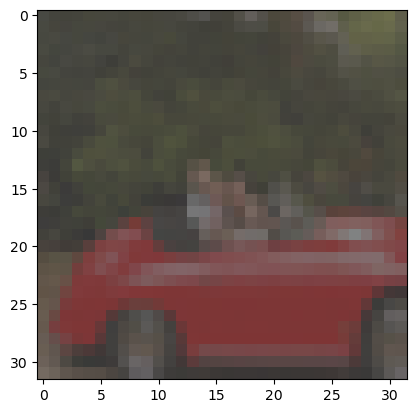

In [23]:
# visualizing a sample from train dataset
image, label = train_dataset[99]
print(label)
print(image.shape)
plt.imshow(image.permute(1,2,0))
plt.show()

tensor(7)
torch.Size([3, 32, 32])


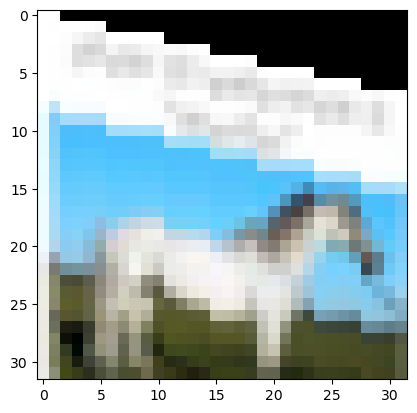

In [24]:
# visualizing a sample from train loader
# torchvision.transforms.ToTensor() converts a PIL Image or numpy.ndarray (H x W x C)
# in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
train_iter = iter(train_loader)
batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
print(label)
print(image.shape)
plt.imshow(image.permute(1,2,0))
plt.show()

## Building the model

CNN's have a typical VGG architecture that involves CONV -> CONV-> Maxpool -> .... -> FC -> ... Output

In [25]:
# construct the architecture of the CNN model
class CNN(nn.Module):
  # CIFAR-10 is 3x32x32, b is the batch size
  def __init__(self):
    super().__init__()

    # VGG MODEL
    # CONV->CONV->POOL

    # 3x32x32 -> 64x32x32
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())

    # 64x32x32 -> 64x16x16
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2))

    # 64x16x16 -> 128x16x16
    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU())

    # 128x16x16 -> 128x8x8
    self.layer4 =  nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2))

    # 128x8x8 -> 256x8x8
    self.layer5 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU())

    # 256x8x8 -> 256x4x4
    self.layer6 =  nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2))

    # bx256x4x4 ->bx(256x4x4)
    self.fc = nn.Sequential(
        nn.Flatten())

    # bx(256*4*4) -> bx256
    self.fc1 = nn.Sequential(
        nn.Linear(256*4*4, 512),
        nn.ReLU())

    # bx256 -> bx10
    self.fc2 = nn.Sequential(
        nn.Linear(512, 10))

  def forward(self, x):
    # input 3x32x32, output 32x32x32
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.layer6(out)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [26]:
# Sanity check
cnn = CNN()
print(cnn(torch.randn(128, 3, 32, 32)).shape)
del cnn

torch.Size([128, 10])


In [28]:
# create an instance of CNN class
model = CNN()
model.to(device) # specify that this model will be stored on the device you chose earlier (GPU or CPU)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [29]:
# loss function
criterion = nn.CrossEntropyLoss()

In [30]:
# optimizer: adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [31]:
# reduce learning rate when a metric has stopped improving
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.5, min_lr=0.0001, patience=3, verbose=1)

## Training

In [32]:
# training function
def train_one_epoch(model, train_loader, optimizer, criterion, device):
  # sets the module in training mode
  model.train()

  correct = 0
  for i, batch in tqdm(enumerate(train_loader)):  # looping through
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    # bx10, want to do argmax on the "10" dimension
    predictions = outputs.argmax(dim=1)
    correct += (predictions == labels).sum().item()
    # Computes the gradients and stores it in the model parameters' .grad
    # attribute (this is backprop or autodiff)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  accuracy = 100 * correct / len(train_dataset)
  print('End of epoch train loss:', round(loss.item(), 3))
  print(f"End of epoch train accuracy: {accuracy}%")

  return loss.item(), accuracy

## Testing

In [33]:
# validation/testing function
def test(model, test_loader, device):
  # the classes - these are from the cifar-10 dataset
  # classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  # sets the module in evaluation mode
  model.eval()

  # average the loss of batches
  running_loss = 0.0
  correct = 0
  for i, batch in tqdm(enumerate(test_loader)):
    # print("i:", i)
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    # bx10, want to do argmax on the "10" dimension
    predictions = outputs.argmax(dim=1)
    correct += (predictions == labels).sum().item()

  epoch_loss = running_loss / len(test_dataset)
  epoch_accu = 100 * correct / len(test_dataset)
  print('End of epoch val loss:', round(epoch_loss, 3))
  print(f"End of epoch val accuracy: {epoch_accu}%")

  # visualizing the current model's performance
  for i in range(2):
    print("Guess:", predictions[i], "Label:", labels[i])
    print('Guess:', classes[predictions[i]], '| Label:', classes[labels[i]])
    plt.imshow(inputs[i].cpu().permute(1,2,0))
    plt.show()

  return epoch_loss, epoch_accu

# Running the train-test loop

Save the model weights of the best epoch (highest val_accuracy)

Epoch:  1


0it [00:00, ?it/s]

End of epoch train loss: 0.65
End of epoch train accuracy: 69.224%


0it [00:00, ?it/s]

End of epoch val loss: 0.661
End of epoch val accuracy: 77.07%
Guess: tensor(8, device='cuda:0') Label: tensor(8, device='cuda:0')
Guess: ship | Label: ship


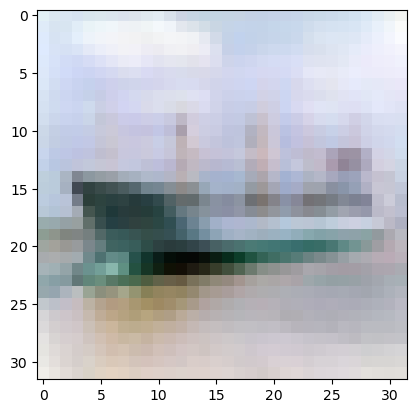

Guess: tensor(6, device='cuda:0') Label: tensor(6, device='cuda:0')
Guess: frog | Label: frog


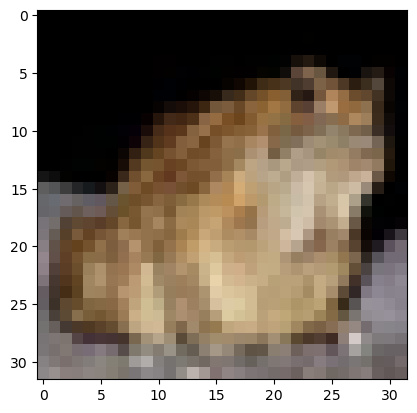

Epoch: 1 val_accuracy improved from inf to 77.07, saving model to ./best_model_s3.pth
Epoch:  2


0it [00:00, ?it/s]

End of epoch train loss: 0.774
End of epoch train accuracy: 72.844%


0it [00:00, ?it/s]

End of epoch val loss: 0.725
End of epoch val accuracy: 74.5%
Guess: tensor(3, device='cuda:0') Label: tensor(3, device='cuda:0')
Guess: cat | Label: cat


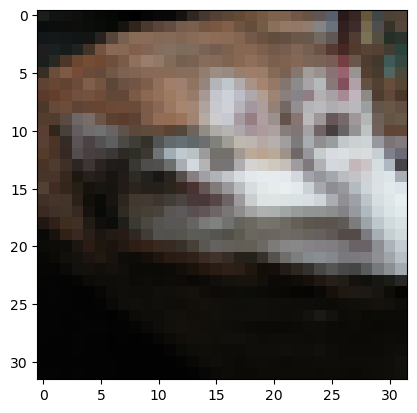

Guess: tensor(6, device='cuda:0') Label: tensor(6, device='cuda:0')
Guess: frog | Label: frog


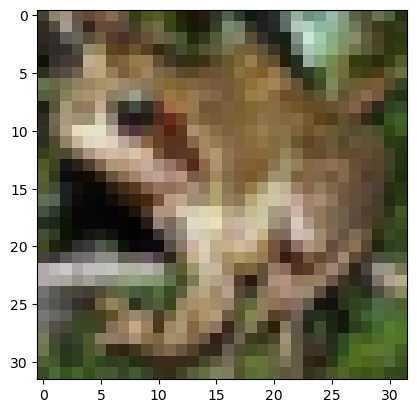

Epoch: 2 val_accuracy did not improve from 77.07
Epoch:  3


0it [00:00, ?it/s]

End of epoch train loss: 0.844
End of epoch train accuracy: 75.646%


0it [00:00, ?it/s]

End of epoch val loss: 0.635
End of epoch val accuracy: 78.12%
Guess: tensor(9, device='cuda:0') Label: tensor(9, device='cuda:0')
Guess: truck | Label: truck


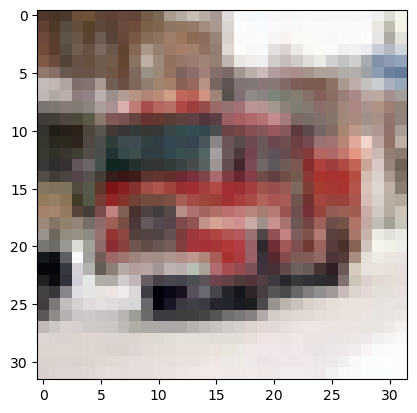

Guess: tensor(2, device='cuda:0') Label: tensor(2, device='cuda:0')
Guess: bird | Label: bird


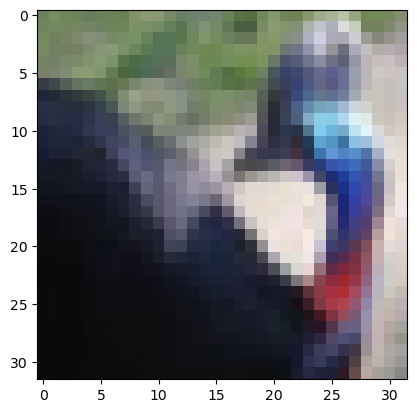

Epoch: 3 val_accuracy improved from 77.07 to 78.12, saving model to ./best_model_s3.pth
Epoch:  4


0it [00:00, ?it/s]

End of epoch train loss: 0.672
End of epoch train accuracy: 77.726%


0it [00:00, ?it/s]

End of epoch val loss: 0.511
End of epoch val accuracy: 82.51%
Guess: tensor(0, device='cuda:0') Label: tensor(0, device='cuda:0')
Guess: airplane | Label: airplane


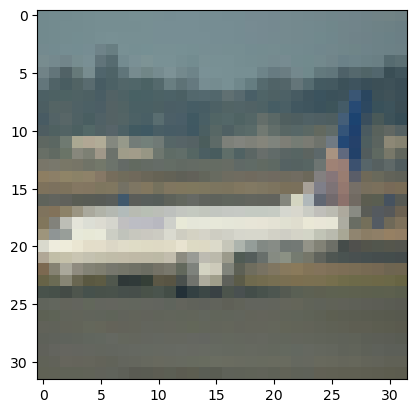

Guess: tensor(3, device='cuda:0') Label: tensor(7, device='cuda:0')
Guess: cat | Label: horse


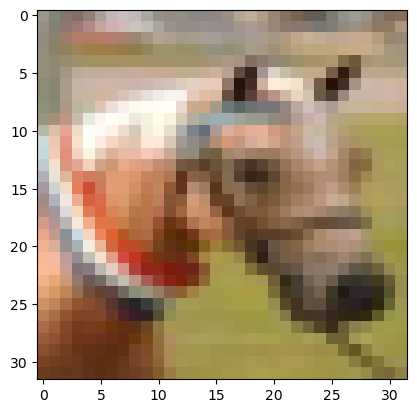

Epoch: 4 val_accuracy improved from 78.12 to 82.51, saving model to ./best_model_s3.pth
Epoch:  5


0it [00:00, ?it/s]

End of epoch train loss: 0.767
End of epoch train accuracy: 79.582%


0it [00:00, ?it/s]

End of epoch val loss: 0.575
End of epoch val accuracy: 80.47%
Guess: tensor(0, device='cuda:0') Label: tensor(0, device='cuda:0')
Guess: airplane | Label: airplane


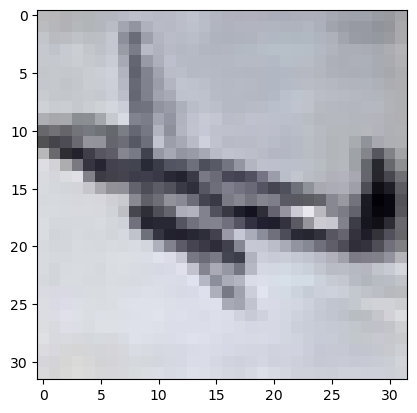

Guess: tensor(1, device='cuda:0') Label: tensor(1, device='cuda:0')
Guess: automobile | Label: automobile


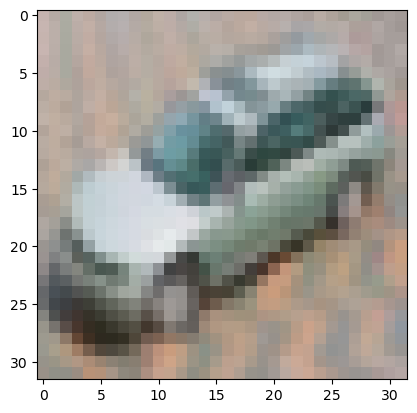

Epoch: 5 val_accuracy did not improve from 82.51
Epoch:  6


0it [00:00, ?it/s]

End of epoch train loss: 0.694
End of epoch train accuracy: 81.378%


0it [00:00, ?it/s]

End of epoch val loss: 0.474
End of epoch val accuracy: 83.92%
Guess: tensor(3, device='cuda:0') Label: tensor(2, device='cuda:0')
Guess: cat | Label: bird


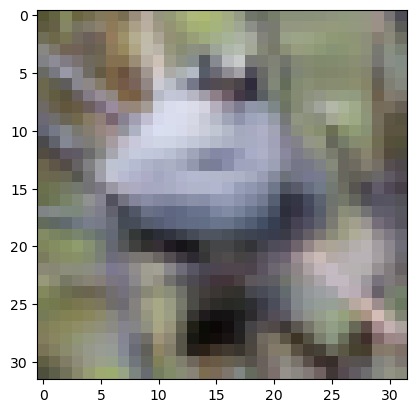

Guess: tensor(9, device='cuda:0') Label: tensor(9, device='cuda:0')
Guess: truck | Label: truck


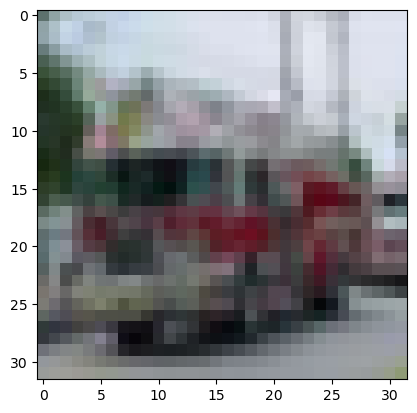

Epoch: 6 val_accuracy improved from 82.51 to 83.92, saving model to ./best_model_s3.pth
Epoch:  7


0it [00:00, ?it/s]

End of epoch train loss: 0.612
End of epoch train accuracy: 82.592%


0it [00:00, ?it/s]

End of epoch val loss: 0.486
End of epoch val accuracy: 83.56%
Guess: tensor(9, device='cuda:0') Label: tensor(9, device='cuda:0')
Guess: truck | Label: truck


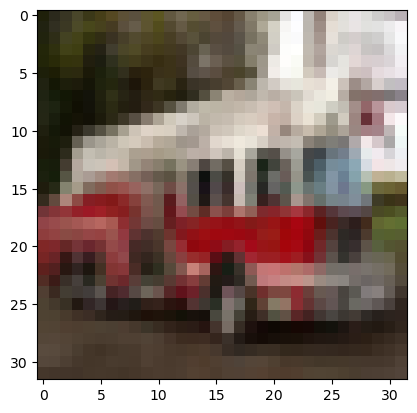

Guess: tensor(9, device='cuda:0') Label: tensor(9, device='cuda:0')
Guess: truck | Label: truck


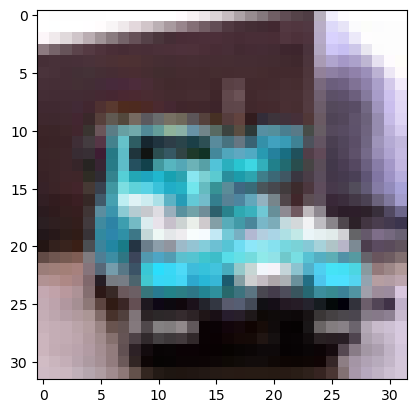

Epoch: 7 val_accuracy did not improve from 83.92
Epoch:  8


0it [00:00, ?it/s]

End of epoch train loss: 0.456
End of epoch train accuracy: 83.892%


0it [00:00, ?it/s]

End of epoch val loss: 0.513
End of epoch val accuracy: 82.96%
Guess: tensor(6, device='cuda:0') Label: tensor(6, device='cuda:0')
Guess: frog | Label: frog


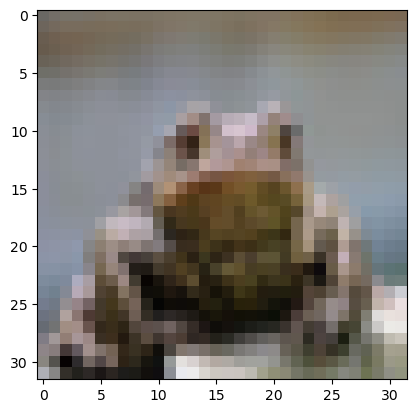

Guess: tensor(2, device='cuda:0') Label: tensor(2, device='cuda:0')
Guess: bird | Label: bird


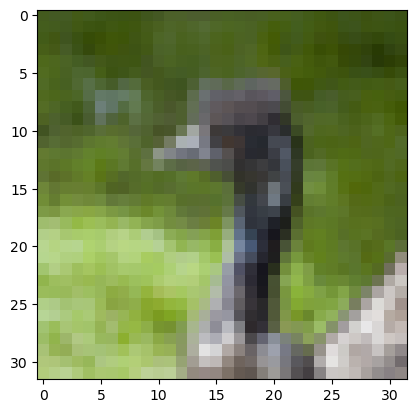

Epoch: 8 val_accuracy did not improve from 83.92
Epoch:  9


0it [00:00, ?it/s]

End of epoch train loss: 0.477
End of epoch train accuracy: 85.17%


0it [00:00, ?it/s]

End of epoch val loss: 0.612
End of epoch val accuracy: 81.19%
Guess: tensor(1, device='cuda:0') Label: tensor(1, device='cuda:0')
Guess: automobile | Label: automobile


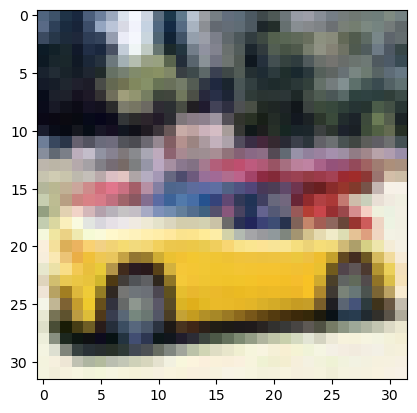

Guess: tensor(0, device='cuda:0') Label: tensor(0, device='cuda:0')
Guess: airplane | Label: airplane


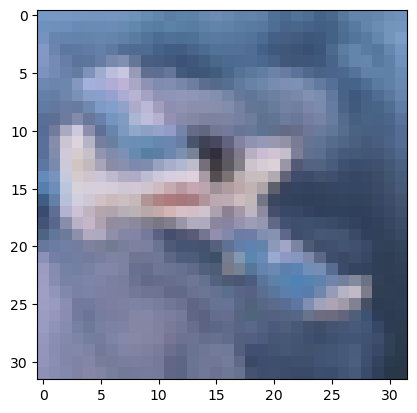

Epoch: 9 val_accuracy did not improve from 83.92
Epoch:  10


0it [00:00, ?it/s]

End of epoch train loss: 0.513
End of epoch train accuracy: 85.828%


0it [00:00, ?it/s]

End of epoch val loss: 0.484
End of epoch val accuracy: 84.28%
Guess: tensor(9, device='cuda:0') Label: tensor(9, device='cuda:0')
Guess: truck | Label: truck


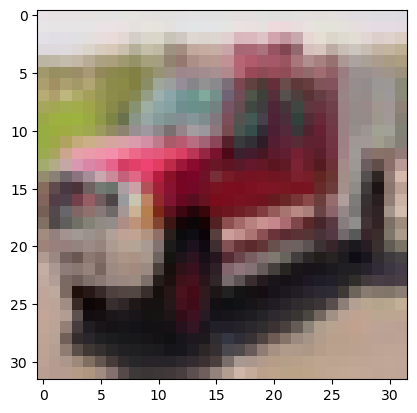

Guess: tensor(8, device='cuda:0') Label: tensor(8, device='cuda:0')
Guess: ship | Label: ship


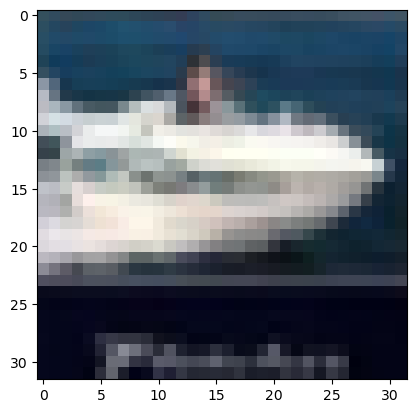

Epoch: 10 val_accuracy improved from 83.92 to 84.28, saving model to ./best_model_s3.pth
Epoch:  11


0it [00:00, ?it/s]

End of epoch train loss: 0.424
End of epoch train accuracy: 86.848%


0it [00:00, ?it/s]

End of epoch val loss: 0.464
End of epoch val accuracy: 84.97%
Guess: tensor(2, device='cuda:0') Label: tensor(3, device='cuda:0')
Guess: bird | Label: cat


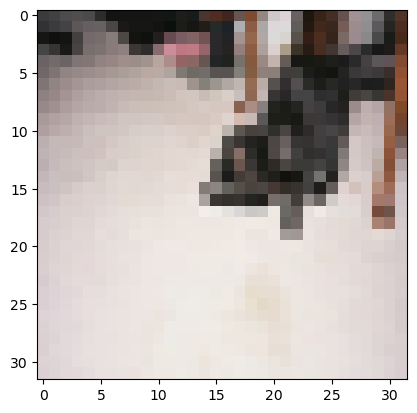

Guess: tensor(5, device='cuda:0') Label: tensor(3, device='cuda:0')
Guess: dog | Label: cat


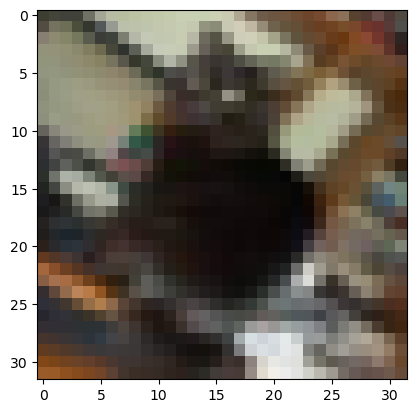

Epoch: 11 val_accuracy improved from 84.28 to 84.97, saving model to ./best_model_s3.pth
Epoch:  12


0it [00:00, ?it/s]

End of epoch train loss: 0.24
End of epoch train accuracy: 87.736%


0it [00:00, ?it/s]

End of epoch val loss: 0.543
End of epoch val accuracy: 83.97%
Guess: tensor(8, device='cuda:0') Label: tensor(2, device='cuda:0')
Guess: ship | Label: bird


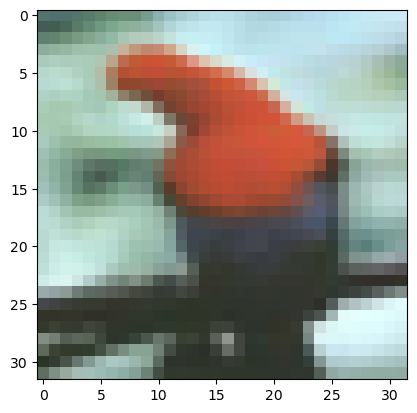

Guess: tensor(3, device='cuda:0') Label: tensor(7, device='cuda:0')
Guess: cat | Label: horse


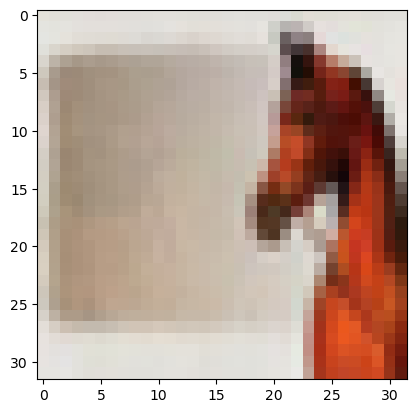

Epoch: 12 val_accuracy did not improve from 84.97
Epoch:  13


0it [00:00, ?it/s]

End of epoch train loss: 0.286
End of epoch train accuracy: 88.31%


0it [00:00, ?it/s]

End of epoch val loss: 0.446
End of epoch val accuracy: 86.05%
Guess: tensor(5, device='cuda:0') Label: tensor(5, device='cuda:0')
Guess: dog | Label: dog


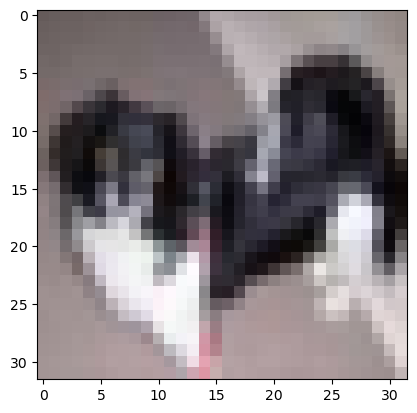

Guess: tensor(6, device='cuda:0') Label: tensor(6, device='cuda:0')
Guess: frog | Label: frog


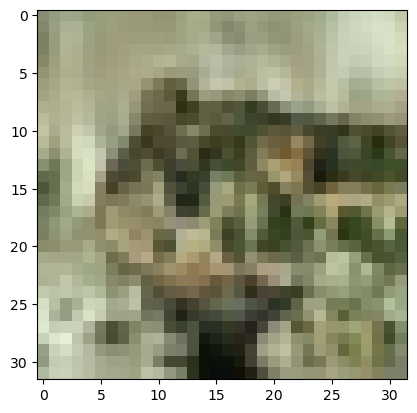

Epoch: 13 val_accuracy improved from 84.97 to 86.05, saving model to ./best_model_s3.pth
Epoch:  14


0it [00:00, ?it/s]

End of epoch train loss: 0.391
End of epoch train accuracy: 88.912%


0it [00:00, ?it/s]

End of epoch val loss: 0.471
End of epoch val accuracy: 85.51%
Guess: tensor(2, device='cuda:0') Label: tensor(2, device='cuda:0')
Guess: bird | Label: bird


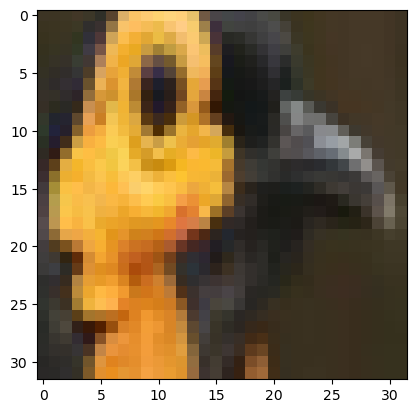

Guess: tensor(0, device='cuda:0') Label: tensor(0, device='cuda:0')
Guess: airplane | Label: airplane


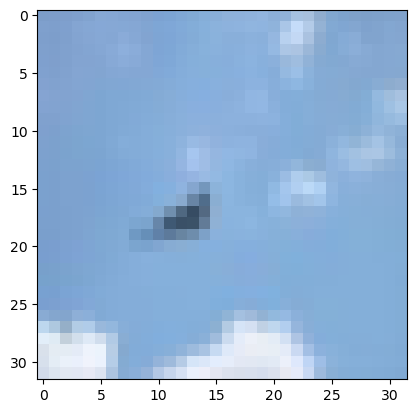

Epoch: 14 val_accuracy did not improve from 86.05
Epoch:  15


0it [00:00, ?it/s]

End of epoch train loss: 0.233
End of epoch train accuracy: 89.642%


0it [00:00, ?it/s]

End of epoch val loss: 0.439
End of epoch val accuracy: 86.25%
Guess: tensor(9, device='cuda:0') Label: tensor(0, device='cuda:0')
Guess: truck | Label: airplane


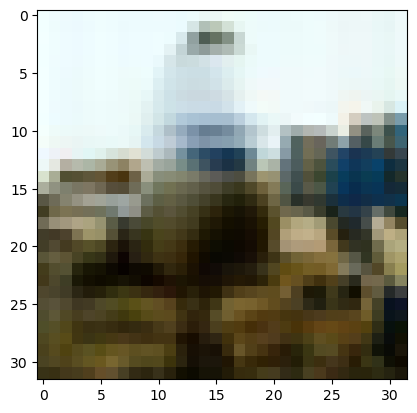

Guess: tensor(8, device='cuda:0') Label: tensor(8, device='cuda:0')
Guess: ship | Label: ship


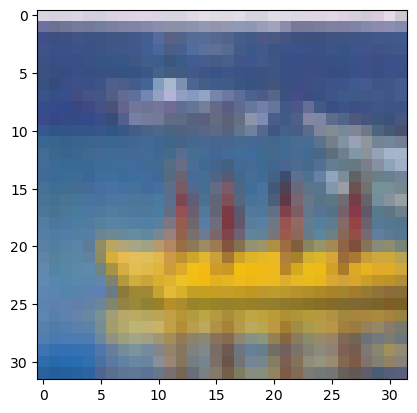

Epoch: 15 val_accuracy improved from 86.05 to 86.25, saving model to ./best_model_s3.pth
Epoch:  16


0it [00:00, ?it/s]

End of epoch train loss: 0.205
End of epoch train accuracy: 90.166%


0it [00:00, ?it/s]

End of epoch val loss: 0.484
End of epoch val accuracy: 85.54%
Guess: tensor(8, device='cuda:0') Label: tensor(8, device='cuda:0')
Guess: ship | Label: ship


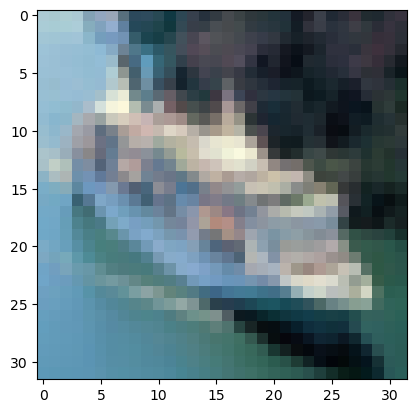

Guess: tensor(7, device='cuda:0') Label: tensor(7, device='cuda:0')
Guess: horse | Label: horse


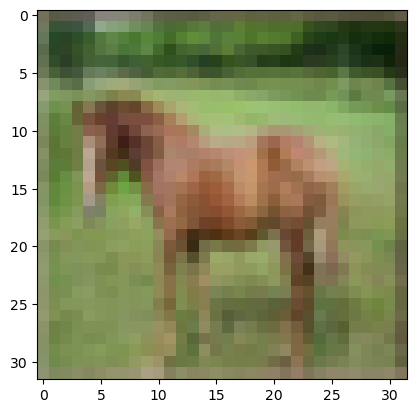

Epoch: 16 val_accuracy did not improve from 86.25
Epoch:  17


0it [00:00, ?it/s]

End of epoch train loss: 0.34
End of epoch train accuracy: 90.5%


0it [00:00, ?it/s]

End of epoch val loss: 0.519
End of epoch val accuracy: 85.41%
Guess: tensor(9, device='cuda:0') Label: tensor(9, device='cuda:0')
Guess: truck | Label: truck


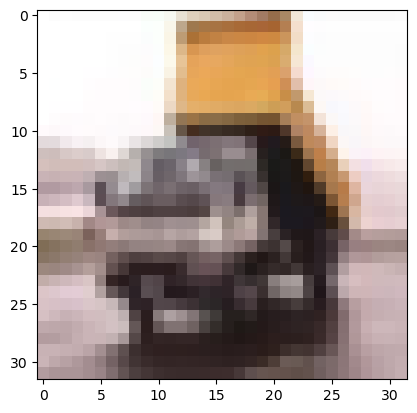

Guess: tensor(0, device='cuda:0') Label: tensor(0, device='cuda:0')
Guess: airplane | Label: airplane


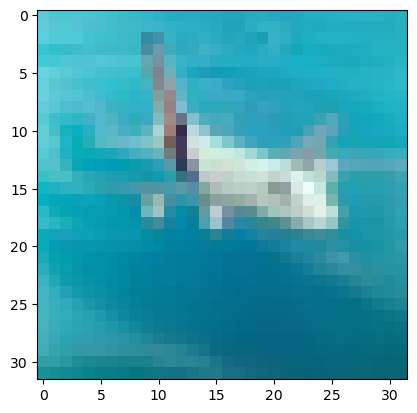

Epoch: 17 val_accuracy did not improve from 86.25
Epoch:  18


0it [00:00, ?it/s]

End of epoch train loss: 0.257
End of epoch train accuracy: 90.766%


0it [00:00, ?it/s]

End of epoch val loss: 0.498
End of epoch val accuracy: 86.28%
Guess: tensor(6, device='cuda:0') Label: tensor(6, device='cuda:0')
Guess: frog | Label: frog


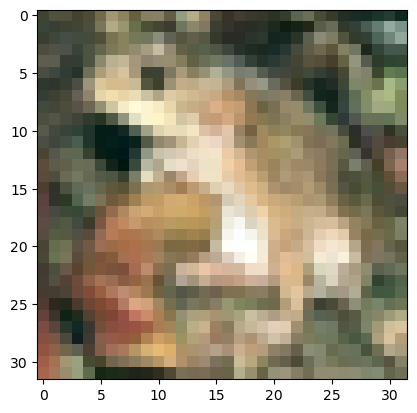

Guess: tensor(2, device='cuda:0') Label: tensor(2, device='cuda:0')
Guess: bird | Label: bird


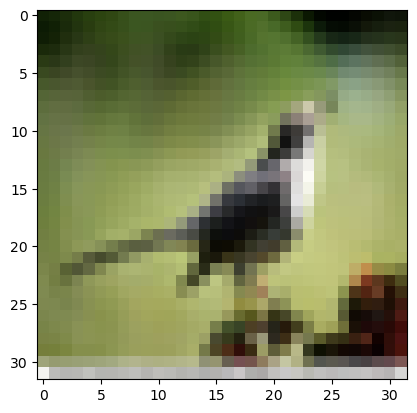

Epoch: 18 val_accuracy improved from 86.25 to 86.28, saving model to ./best_model_s3.pth
Epoch:  19


0it [00:00, ?it/s]

End of epoch train loss: 0.297
End of epoch train accuracy: 91.106%


0it [00:00, ?it/s]

End of epoch val loss: 0.488
End of epoch val accuracy: 85.97%
Guess: tensor(9, device='cuda:0') Label: tensor(9, device='cuda:0')
Guess: truck | Label: truck


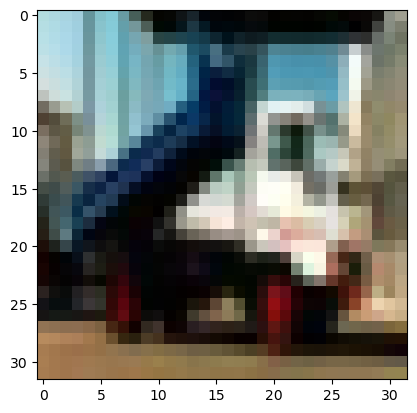

Guess: tensor(2, device='cuda:0') Label: tensor(2, device='cuda:0')
Guess: bird | Label: bird


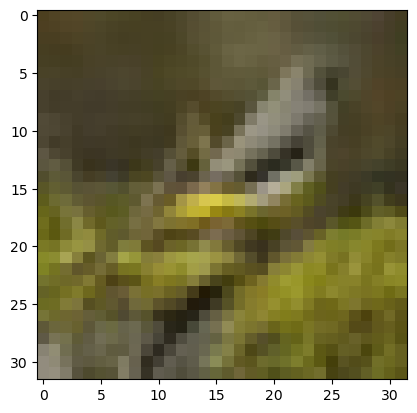

Epoch: 19 val_accuracy did not improve from 86.28
Epoch:  20


0it [00:00, ?it/s]

End of epoch train loss: 0.25
End of epoch train accuracy: 91.558%


0it [00:00, ?it/s]

End of epoch val loss: 0.616
End of epoch val accuracy: 83.55%
Guess: tensor(1, device='cuda:0') Label: tensor(1, device='cuda:0')
Guess: automobile | Label: automobile


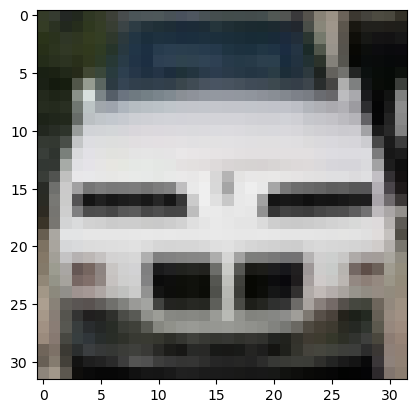

Guess: tensor(8, device='cuda:0') Label: tensor(8, device='cuda:0')
Guess: ship | Label: ship


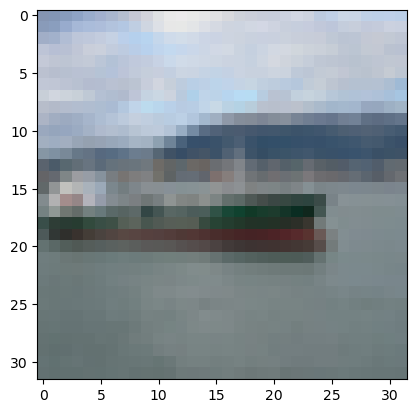

Epoch: 20 val_accuracy did not improve from 86.28
Epoch:  21


0it [00:00, ?it/s]

End of epoch train loss: 0.286
End of epoch train accuracy: 91.662%


0it [00:00, ?it/s]

End of epoch val loss: 0.492
End of epoch val accuracy: 86.17%
Guess: tensor(2, device='cuda:0') Label: tensor(4, device='cuda:0')
Guess: bird | Label: deer


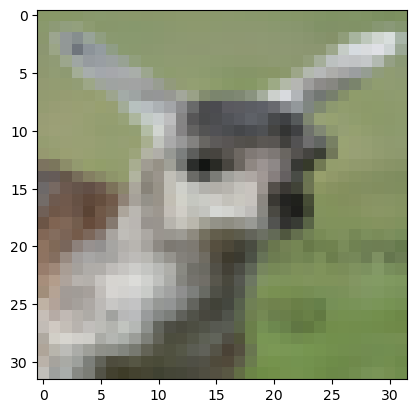

Guess: tensor(7, device='cuda:0') Label: tensor(7, device='cuda:0')
Guess: horse | Label: horse


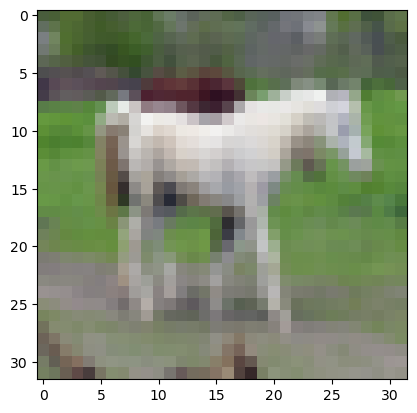

Epoch: 21 val_accuracy did not improve from 86.28
Epoch:  22


0it [00:00, ?it/s]

End of epoch train loss: 0.286
End of epoch train accuracy: 91.946%


0it [00:00, ?it/s]

End of epoch val loss: 0.502
End of epoch val accuracy: 86.67%
Guess: tensor(2, device='cuda:0') Label: tensor(2, device='cuda:0')
Guess: bird | Label: bird


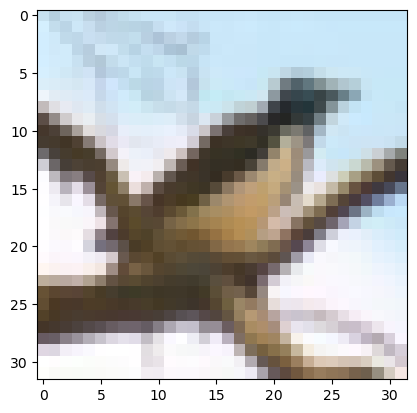

Guess: tensor(5, device='cuda:0') Label: tensor(5, device='cuda:0')
Guess: dog | Label: dog


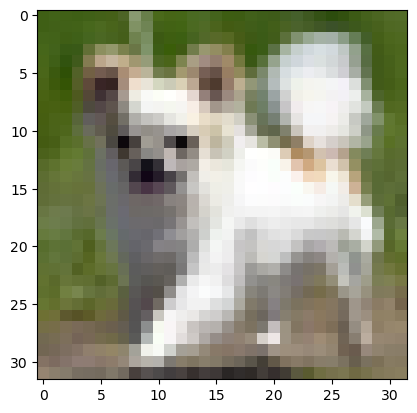

Epoch: 22 val_accuracy improved from 86.28 to 86.67, saving model to ./best_model_s3.pth
Epoch:  23


0it [00:00, ?it/s]

End of epoch train loss: 0.427
End of epoch train accuracy: 92.074%


0it [00:00, ?it/s]

End of epoch val loss: 0.502
End of epoch val accuracy: 85.95%
Guess: tensor(1, device='cuda:0') Label: tensor(1, device='cuda:0')
Guess: automobile | Label: automobile


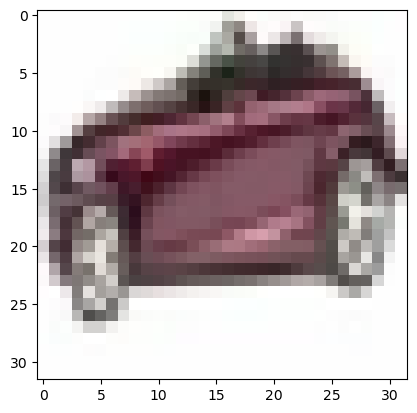

Guess: tensor(0, device='cuda:0') Label: tensor(0, device='cuda:0')
Guess: airplane | Label: airplane


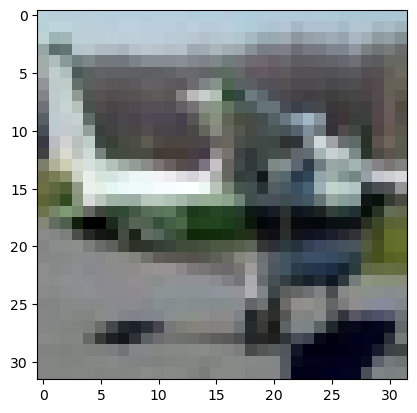

Epoch: 23 val_accuracy did not improve from 86.67
Epoch:  24


0it [00:00, ?it/s]

End of epoch train loss: 0.312
End of epoch train accuracy: 92.352%


0it [00:00, ?it/s]

End of epoch val loss: 0.543
End of epoch val accuracy: 85.99%
Guess: tensor(9, device='cuda:0') Label: tensor(9, device='cuda:0')
Guess: truck | Label: truck


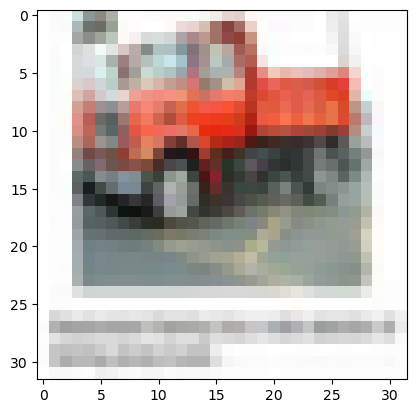

Guess: tensor(6, device='cuda:0') Label: tensor(6, device='cuda:0')
Guess: frog | Label: frog


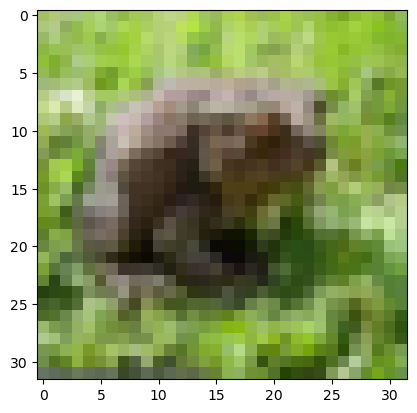

Epoch: 24 val_accuracy did not improve from 86.67
Epoch:  25


0it [00:00, ?it/s]

End of epoch train loss: 0.247
End of epoch train accuracy: 92.386%


0it [00:00, ?it/s]

End of epoch val loss: 0.496
End of epoch val accuracy: 86.8%
Guess: tensor(4, device='cuda:0') Label: tensor(2, device='cuda:0')
Guess: deer | Label: bird


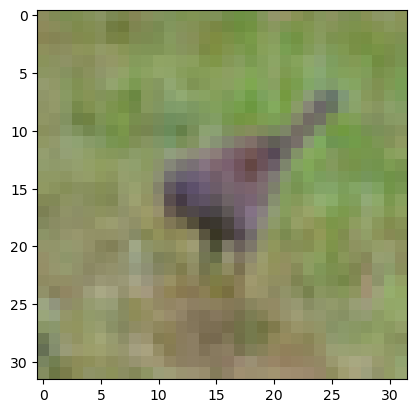

Guess: tensor(6, device='cuda:0') Label: tensor(6, device='cuda:0')
Guess: frog | Label: frog


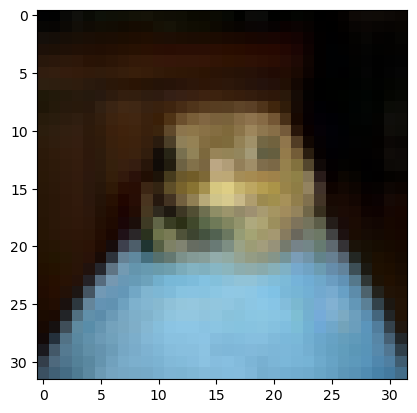

Epoch: 25 val_accuracy improved from 86.67 to 86.8, saving model to ./best_model_s3.pth
Epoch:  26


0it [00:00, ?it/s]

End of epoch train loss: 0.321
End of epoch train accuracy: 92.318%


0it [00:00, ?it/s]

End of epoch val loss: 0.457
End of epoch val accuracy: 87.34%
Guess: tensor(8, device='cuda:0') Label: tensor(8, device='cuda:0')
Guess: ship | Label: ship


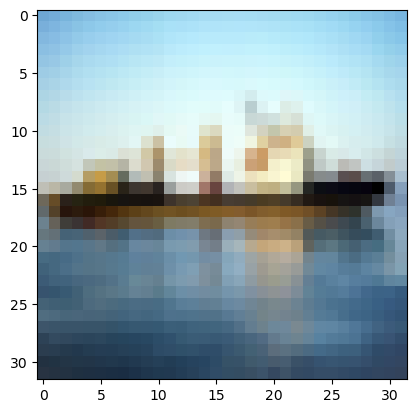

Guess: tensor(3, device='cuda:0') Label: tensor(3, device='cuda:0')
Guess: cat | Label: cat


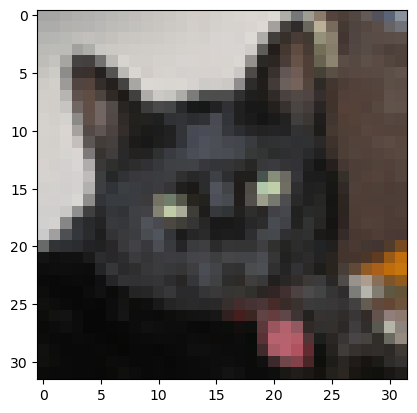

Epoch: 26 val_accuracy improved from 86.8 to 87.34, saving model to ./best_model_s3.pth
Epoch:  27


0it [00:00, ?it/s]

End of epoch train loss: 0.198
End of epoch train accuracy: 92.756%


0it [00:00, ?it/s]

End of epoch val loss: 0.478
End of epoch val accuracy: 87.35%
Guess: tensor(1, device='cuda:0') Label: tensor(1, device='cuda:0')
Guess: automobile | Label: automobile


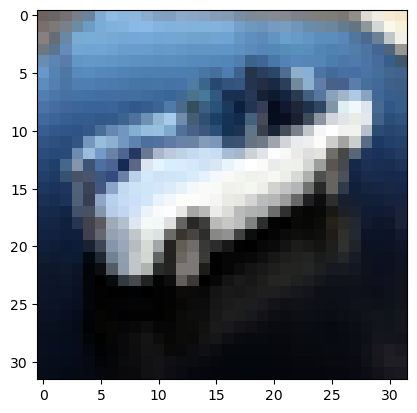

Guess: tensor(1, device='cuda:0') Label: tensor(1, device='cuda:0')
Guess: automobile | Label: automobile


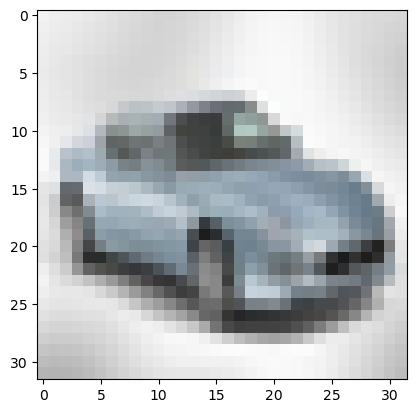

Epoch: 27 val_accuracy improved from 87.34 to 87.35, saving model to ./best_model_s3.pth
Epoch:  28


0it [00:00, ?it/s]

End of epoch train loss: 0.143
End of epoch train accuracy: 92.612%


0it [00:00, ?it/s]

End of epoch val loss: 0.541
End of epoch val accuracy: 86.66%
Guess: tensor(6, device='cuda:0') Label: tensor(6, device='cuda:0')
Guess: frog | Label: frog


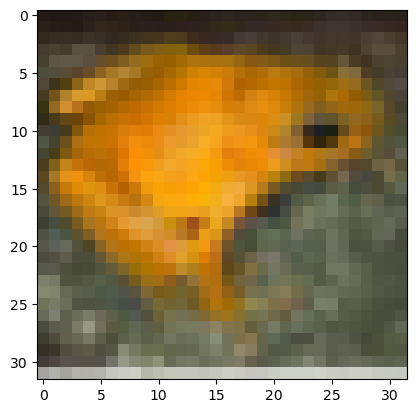

Guess: tensor(7, device='cuda:0') Label: tensor(7, device='cuda:0')
Guess: horse | Label: horse


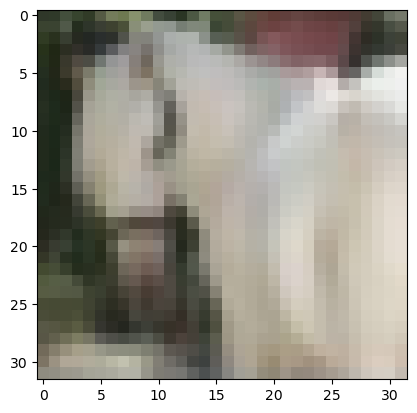

Epoch: 28 val_accuracy did not improve from 87.35
Epoch:  29


0it [00:00, ?it/s]

End of epoch train loss: 0.209
End of epoch train accuracy: 92.906%


0it [00:00, ?it/s]

End of epoch val loss: 0.497
End of epoch val accuracy: 87.06%
Guess: tensor(9, device='cuda:0') Label: tensor(9, device='cuda:0')
Guess: truck | Label: truck


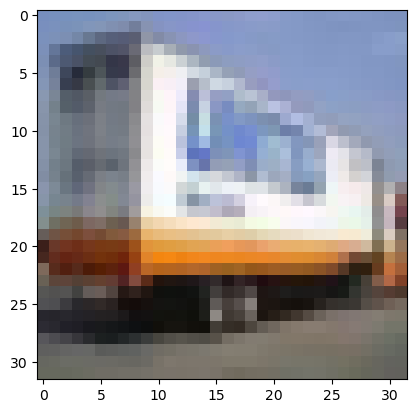

Guess: tensor(8, device='cuda:0') Label: tensor(8, device='cuda:0')
Guess: ship | Label: ship


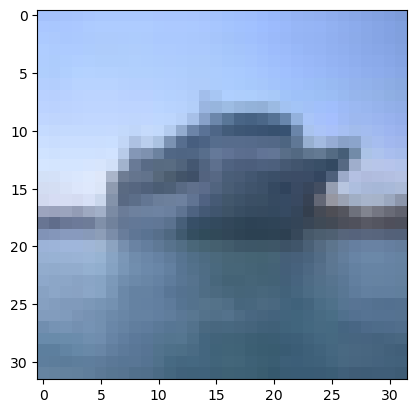

Epoch: 29 val_accuracy did not improve from 87.35
Epoch:  30


0it [00:00, ?it/s]

End of epoch train loss: 0.328
End of epoch train accuracy: 92.996%


0it [00:00, ?it/s]

End of epoch val loss: 0.523
End of epoch val accuracy: 86.93%
Guess: tensor(3, device='cuda:0') Label: tensor(3, device='cuda:0')
Guess: cat | Label: cat


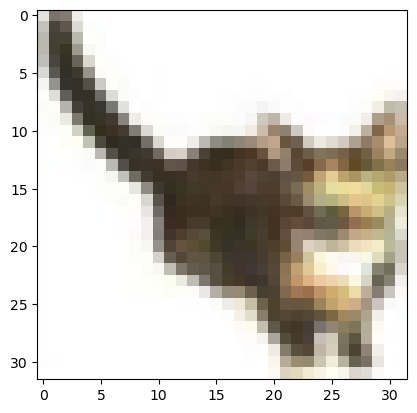

Guess: tensor(8, device='cuda:0') Label: tensor(8, device='cuda:0')
Guess: ship | Label: ship


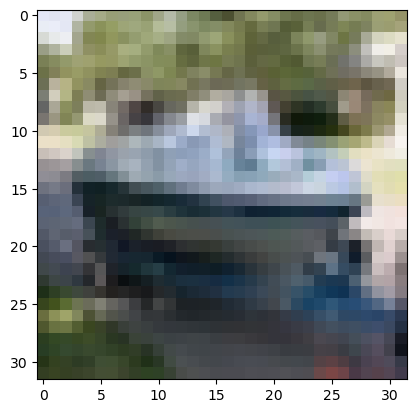

Epoch: 30 val_accuracy did not improve from 87.35
Best epoch: 27, val_accuracy: 87.35
Training time: 927.2250528335571


In [38]:
# run a loop which calls the training and testing functions
NUM_EPOCHS = 30

# parameters for early stopping
start_from_epoch = 10
patience = 5
counter = 0

# best val loss
best_accuracy = float('inf')
best_epoch = -1

# save the loss and accuracy for plotting later
df_loss = pd.DataFrame(columns=['train', 'validation'])
df_acc = pd.DataFrame(columns=['train', 'validation'])

t0 = time.time()
for epoch in range(NUM_EPOCHS):
  print("Epoch: ", epoch + 1)

  # train the model
  loss1, accuracy1 = train_one_epoch(model, train_loader, optimizer, criterion, device)

  # test the model
  loss2, accuracy2 = test(model, test_loader, device)

  # save the loss and accuracy of the epoch
  df_loss.loc[len(df_loss.index)] = [loss1, loss2]
  df_acc.loc[len(df_acc.index)] = [accuracy1, accuracy2]

  # reduce learning rate if val_accuracy has stopped improving
  scheduler.step(accuracy2)

  # save the weights of the best model (highest val_accuracy)
  val_accuracy = accuracy2
  if epoch == 0 or val_accuracy > best_accuracy:
    # val_accuracy improved from the best val loss
    print("Epoch:", str(epoch + 1), "val_accuracy improved from", str(best_accuracy),
          "to", str(val_accuracy) + ", saving model to", "./best_model_s3.pth")
    torch.save(model.state_dict(), "./best_model_s3.pth")
    best_accuracy = val_accuracy
    best_epoch = epoch;
    counter = 0
  else:
    # val_accuracy did not improve from the best val_accuracy
    print("Epoch:", str(epoch + 1), "val_accuracy did not improve from", str(best_accuracy))
    counter += 1
    # early stopping the tran-test loop
    if epoch >= start_from_epoch and counter > patience and (epoch + 1) != NUM_EPOCHS:
      print("Epoch:", str(epoch + 1), "early stopping")
      break

print("Best epoch:", str(best_epoch + 1) + ", val_accuracy:", str(best_accuracy))
print("Training time:", time.time()-t0)

Plot train and validation loss and accuracy graphs

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

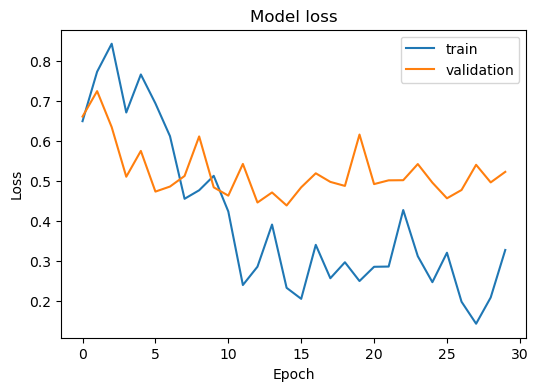

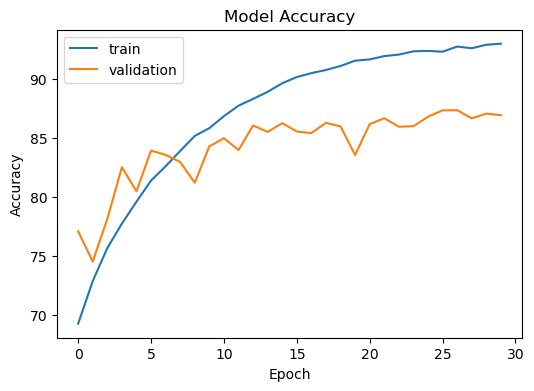

In [40]:
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

In [41]:
size = 0
for param in model.parameters():
  size += np.prod(param.shape)
print(f"Number of parameters: {size}")

Number of parameters: 3249994


## Loading the weights

In [42]:
# reload the weights previously saved
model_new = CNN()
model_new.load_state_dict(torch.load("./best_model_s3.pth"))
model_new.to(device)
model_new.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

0it [00:00, ?it/s]

End of epoch val loss: 0.478
End of epoch val accuracy: 87.35%
Guess: tensor(6, device='cuda:0') Label: tensor(6, device='cuda:0')
Guess: frog | Label: frog


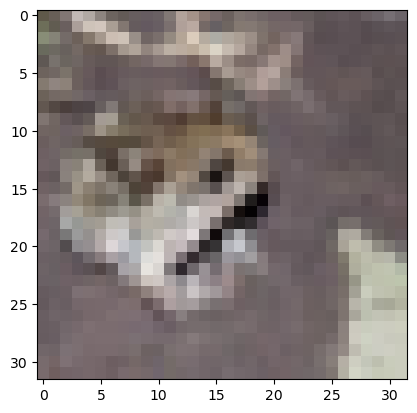

Guess: tensor(1, device='cuda:0') Label: tensor(1, device='cuda:0')
Guess: automobile | Label: automobile


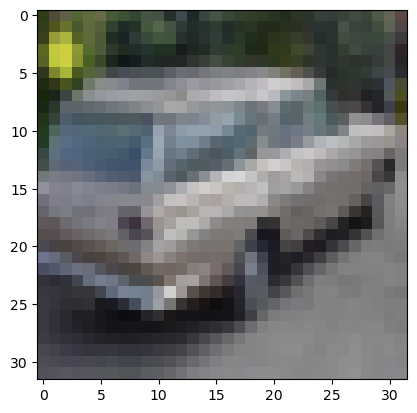

(0.4776525942802429, 87.35)

In [43]:
# test the model
test(model_new, test_loader, device)